In [1]:
import random
import plotly
import warnings
import keras as k
import numpy as np
import pandas as pd
import seaborn as sns
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.model_selection import RepeatedKFold
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import roc_curve, roc_auc_score
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from models.linear_regression.linear_regression import LinearRegression as LR

import config as c
from sklearn.model_selection import train_test_split
from pipeline.Layer import Layer
from utils.cuda import turn_off_gpu
from models.svm.svm import SVM
from utils.metrics import roc_auc_score_at_K
from models.catboost_regression.catboost_regression import CatboostRegressor
from utils.preprocess import preprocess, add_columns, reset_averages
from models.keras_dense_classifier.keras_dense_classifier import KerasDenseClassifier as KDC
from visualization.utils import plot_correlation_matrix, plot_scatterplot_matrix

#turn_off_gpu()
init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')
plt.rcParams ['figure.figsize'] = (13,8)
sns.set()
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('train.csv', sep=',')
pd.set_option('display.max_columns', 500)
df = add_columns(df)
df = preprocess(df)
df

,card_id,target,addr_region_reg,addr_region_fact,sas_limit_after_003_amt,sas_limit_last_amt,clnt_income_month_avg_net_amt,clnt_expense_month_avg_amt,clnt_experience_cur_mnth,clnt_experience_cur_year,clnt_experience_total_mnth,app_addr_region_reg,app_addr_region_fact,app_addr_region_sale,clnt_birth_year,addr_region_fact_encoding1,addr_region_fact_encoding2,addr_region_reg_encoding1,addr_region_reg_encoding2,app_addr_region_reg_encoding1,app_addr_region_reg_encoding2,app_addr_region_fact_encoding1,app_addr_region_fact_encoding2,app_addr_region_sale_encoding1,app_addr_region_sale_encoding2,loans_main_borrower,loans_active,last_loan_date,first_loan_date,max_overdue_status,ttl_officials,ttl_legals,ttl_bankruptcies,inquiry_recent_period,inquiry_3_month,inquiry_6_month,inquiry_9_month,inquiry_12_month,ttl_inquiries,ttl_auto_loan,ttl_mortgage,ttl_credit_card,ttl_consumer,worst_status_ever,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,fl_coborrower,fl_active_coborrower,pay_load,inquiry_1_week,inquiry_1_month,feature_10,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,makro_region,fo,region,feature_30,t_0,t_1,t_2,t_3,t_4,t_0=t_1,t_2=t_3,t_0=t_3,t_4_2000,t_4_364000,t_4_460000,t_4_430000,notnull,delivery_type_cat_1,delivery_type_cat_2,delivery_type_cat_3,channel_name_cat_0,channel_name_cat_1,channel_name_cat_2,channel_name_cat_3,channel_name_cat_4,channel_name_cat_5,channel_name_cat_6,channel_name_2_cat_0,channel_name_2_cat_1,channel_name_2_cat_2,channel_name_2_cat_3,channel_name_2_cat_4,channel_name_2_cat_5,channel_name_modified_2018_cat_0,channel_name_modified_2018_cat_1,channel_name_modified_2018_cat_2,channel_name_modified_2018_cat_3,channel_name_modified_2018_cat_4,clnt_education_name_cat_0,clnt_education_name_cat_1,clnt_education_name_cat_2,clnt_education_name_cat_3,clnt_education_name_cat_4,clnt_education_name_cat_5,clnt_education_name_cat_6,clnt_marital_status_name_cat_0,clnt_marital_status_name_cat_1,clnt_marital_status_name_cat_2,clnt_marital_status_name_cat_3,clnt_marital_status_name_cat_4,clnt_employment_type_name_cat_0,clnt_employment_type_name_cat_1,clnt_employment_type_name_cat_2,clnt_employment_type_name_cat_3,clnt_employment_type_name_cat_4,clnt_speciality_sphere_name_cat_0,clnt_speciality_sphere_name_cat_1,clnt_speciality_sphere_name_cat_10,clnt_speciality_sphere_name_cat_11,clnt_speciality_sphere_name_cat_12,clnt_speciality_sphere_name_cat_13,clnt_speciality_sphere_name_cat_14,clnt_speciality_sphere_name_cat_15,clnt_speciality_sphere_name_cat_16,clnt_speciality_sphere_name_cat_17,clnt_speciality_sphere_name_cat_18,clnt_speciality_sphere_name_cat_19,clnt_speciality_sphere_name_cat_2,clnt_speciality_sphere_name_cat_20,clnt_speciality_sphere_name_cat_21,clnt_speciality_sphere_name_cat_22,clnt_speciality_sphere_name_cat_23,clnt_speciality_sphere_name_cat_24,clnt_speciality_sphere_name_cat_25,clnt_speciality_sphere_name_cat_26,clnt_speciality_sphere_name_cat_27,clnt_speciality_sphere_name_cat_28,clnt_speciality_sphere_name_cat_3,clnt_speciality_sphere_name_cat_4,clnt_speciality_sphere_name_cat_5,clnt_speciality_sphere_name_cat_6,clnt_speciality_sphere_name_cat_7,clnt_speciality_sphere_name_cat_8,clnt_speciality_sphere_name_cat_9,clnt_sex_name_cat_0,clnt_sex_name_cat_1,prt_name_cat_0,prt_name_cat_1,prt_name_cat_2,prt_name_cat_3,prt_name_cat_4,prt_name_cat_5,prt_name_cat_6,prt_name_cat_7,prt_name_cat_8,prt_name_cat_9,feature_0_cat_0,feature_0_cat_1,feature_0_cat_10,feature_0_cat_12,feature_0_cat_13,feature_0_cat_14,feature_0_cat_15,feature_0_cat_16,feature_0_cat_3,feature_0_cat_6,feature_0_cat_7,feature_0_cat_8,feature_0_cat_9
0,cid_10620,1,107,107,1,1,3,0,0.0,0.0,0.0,107,107,45,46,560000,78750,560000,78750,560000,78750,560000,78750,260000,46000,0.88,0.78,193.0,2851.0,2,0.0,0.0,0.0,0.0,7.0,10.0,12.0,19.0,87,0,0,1,1,3,3,10,4,0,0,5,1,0,0,0

In [3]:
X = df[df.columns[2:]].to_numpy()
y = df['target'].to_numpy()
c.SEED = random.randint(0, 10000)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lr=LR()
lr.create_model(LR.default_model_constructor_parameters)
lr.fit_model(X, y)

-0.8633953348936861

In [4]:
cr=CatboostRegressor()
cr.create_model(CatboostRegressor.default_model_constructor_parameters)
cr.fit_model(X, y)

-0.898361963443315

In [5]:
predict = cr.predict(X_test)+lr.predict(X_test)*0.05
predict-=predict.min()
predict/=predict.max()
print(roc_auc_score_at_K(reset_averages(predict), y_test, rate=0.1))

0.9001032435531748


In [4]:
X = df[df.columns[2:]].to_numpy()
y = df['target'].to_numpy()

scores = []
rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=24)
for train, test in rkf.split(X):
    c.SEED = random.randint(0, 10000)
    cr=CatboostRegressor()
    cr.create_model(CatboostRegressor.default_model_constructor_parameters)
    cr.fit_model(X[train], y[train], test_size=0.0)
    score=cr.score(X[test], y[test
    scores.append(score)
print(float(np.mean(scores)))

KeyboardInterrupt: 

In [ ]:
print(roc_auc_score_at_K(reset_averages(predict), y_test, rate=0.1))

In [3]:
from pipeline.Layer import Layer

In [6]:
X = df[df.columns[2:]].to_numpy()
y = df['target'].to_numpy()

scores = []
models = []
rkf = RepeatedKFold(n_splits=10, n_repeats=1)
for train, test in rkf.split(X):
    c.SEED = random.randint(0, 10000)
    cr=CatboostRegressor()
    cr.create_model(CatboostRegressor.default_model_constructor_parameters)
    cr.fit_model(X[train], y[train], test_size=0.0)
    models.append(cr)
    score=cr.score(X[test], y[test])
    scores.append(score)
print(float(np.mean(scores)))
layer=Layer(models[:10])

-0.9020150563095864


In [82]:
dump(models[0], "model.joblib")

['model.joblib']

In [73]:
for i, model in enumerate(models):
    dump(models[i], "models_joblib/models_"+str(i)+"_.joblib")

In [81]:
def reset_averages(predict, k):
    order = pd.np.argsort(-predict)
    top_k = int(k * len(predict))
    predict[(predict < predict[order][top_k]) & (predict > predict[order][-top_k])] = -1
    return predict
print(roc_auc_score_at_K(reset_averages(model.predict(X), k=0.1), y, rate=0.2))
print(roc_auc_score_at_K(reset_averages(model.predict(X), k=0.08), y, rate=0.16))

0.9087857876029491
0.9188055488620931


In [86]:
df.predict=reset_averages(model.predict(X), 0.1)

In [105]:
m=(df.predict!=-1)&(df.predict>0.5)

In [106]:
X = df[m][df.columns[2:]].to_numpy()
y = df[m]['target'].to_numpy()

c.SEED = random.randint(0, 10000)
model = CatBoostRegressor(iterations=1000, learning_rate=3e-2,
                           depth=6, loss_function="RMSE",eval_metric='AUC', random_state=42, verbose=1000,
                           l2_leaf_reg = 3.0, min_data_in_leaf = 1, rsm = 1, diffusion_temperature=10000)
model.fit(X, y)
model.score(X, y)

0:	total: 6.64ms	remaining: 6.64s
999:	total: 4.31s	remaining: 0us


0.27103329761189776

In [107]:
predict=model.predict(X)

In [110]:
sum((predict<0.5)*y)

0

In [129]:
k=0.75
print(sum((1-y)*(predict<k)), sum((y)*(predict<k)), sum((y)*(predict>k)), sum((1-y)*(predict>k)))

592 31 7801 577


In [131]:
sum(1-y)

1169

In [24]:
X = df[df.columns[2:]].to_numpy()
y = df['target'].to_numpy()

predict=
predict=np.sum(list(predict.values()), axis=0)
predict-=predict.min()
predict/=predict.max()
print(roc_auc_score_at_K(reset_averages(predict), y, rate=0.1))

0.9414279197587869


In [51]:
df.predict = reset_averages(df.predict.to_numpy())
m=df.predict!=-1

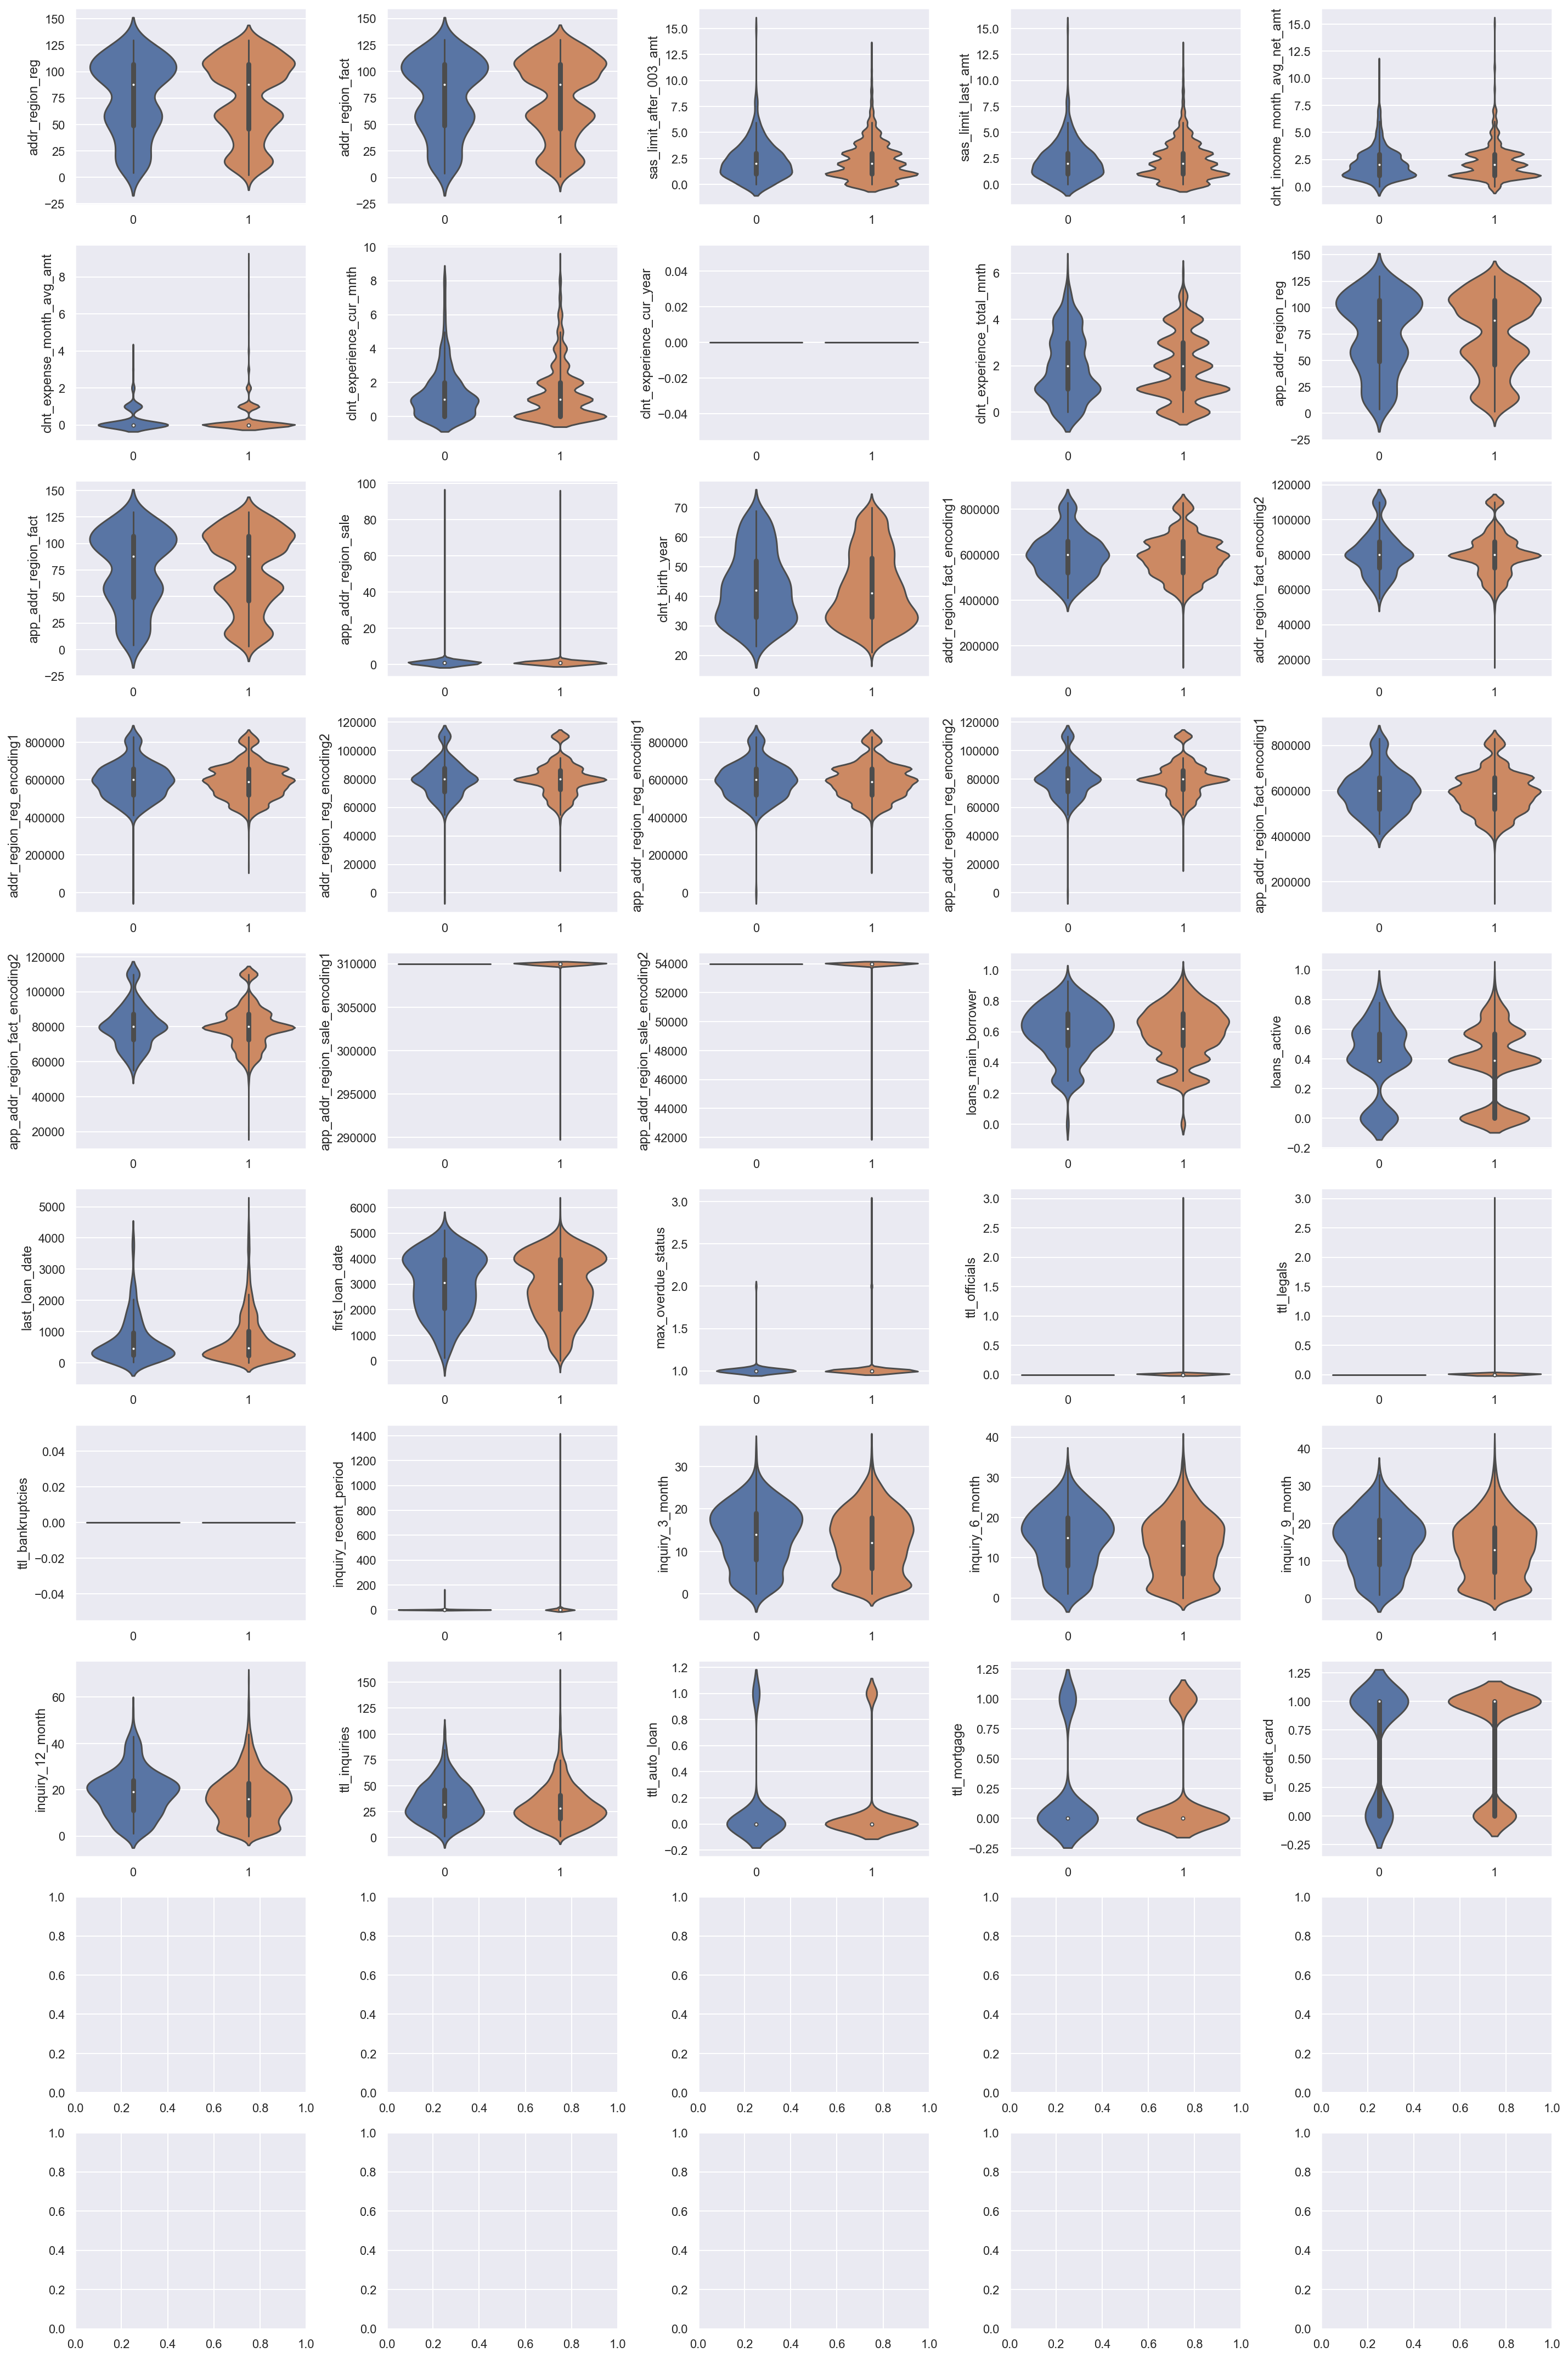

In [59]:
sns.set()


fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(20, 30))
for idx, feat in enumerate(df.columns[2:42]):
    ax = axes[int(idx / 5), idx % 5]
    sns.violinplot(x='target', y=feat, data=df[m&(df.predict>0.5)], ax=ax, scale='area')
    ax.set_xlabel('')
    ax.set_ylabel(feat)
fig.tight_layout()
plt.show()

In [17]:
corr = df.corr()
df = df[list(corr[abs(corr.iloc[:,0])>0.025].iloc[:,0].index)]

In [20]:
X = df[df.columns[2:]].to_numpy()
y = df['target'].to_numpy()

from sklearn.model_selection import RepeatedKFold
scores = []
rkf = RepeatedKFold(n_splits=10, n_repeats=1)
for train, test in rkf.split(X):
    c.SEED = random.randint(0, 10000)
    cr=CatboostRegressor()
    cr.create_model(CatboostRegressor.default_model_constructor_parameters)
    cr.fit_model(X[train], y[train], test_size=0.0)
    score=cr.score(X[test], y[test])
    scores.append(score)
float(np.mean(scores))

-0.9001342906886473

In [76]:
X = df[df.columns[2:]].to_numpy()
y = df['target'].to_numpy()

c.SEED = random.randint(0, 10000)
cr=CatboostRegressor()
cr.create_model(CatboostRegressor.default_model_constructor_parameters)
cr.fit_model(X, y)

0:	total: 11ms	remaining: 11s
999:	total: 9.11s	remaining: 0us


-0.9116723569731277

In [26]:
from catboost import CatBoostRegressor, CatBoostClassifier


model = CatBoostRegressor(iterations=1000, learning_rate=3e-2,
                           depth=6, loss_function="RMSE",eval_metric='AUC', random_state=42, verbose=1000,
                           l2_leaf_reg = 3.0, min_data_in_leaf = 1, rsm = 1, diffusion_temperature=10000)

model.fit(X, y)
print(roc_auc_score_at_K(reset_averages(model.predict(X)), y, rate=0.1))

dump(model, 'catboost.joblib')

0:	total: 11.9ms	remaining: 11.9s
100:	total: 1.07s	remaining: 9.52s
200:	total: 2.1s	remaining: 8.33s
300:	total: 3.11s	remaining: 7.22s
400:	total: 4.13s	remaining: 6.16s
500:	total: 5.14s	remaining: 5.12s
600:	total: 6.17s	remaining: 4.1s
700:	total: 7.21s	remaining: 3.07s
800:	total: 8.25s	remaining: 2.05s
900:	total: 9.29s	remaining: 1.02s
999:	total: 10.3s	remaining: 0us
0.9414459836051957


['catboost.joblib']

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7))
for idx, feat in enumerate(numerical):
    ax = axes[int(idx / 4), idx % 4]
    sns.boxplot(x='Churn', y=feat, data=df, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel(feat)
fig.tight_layout();

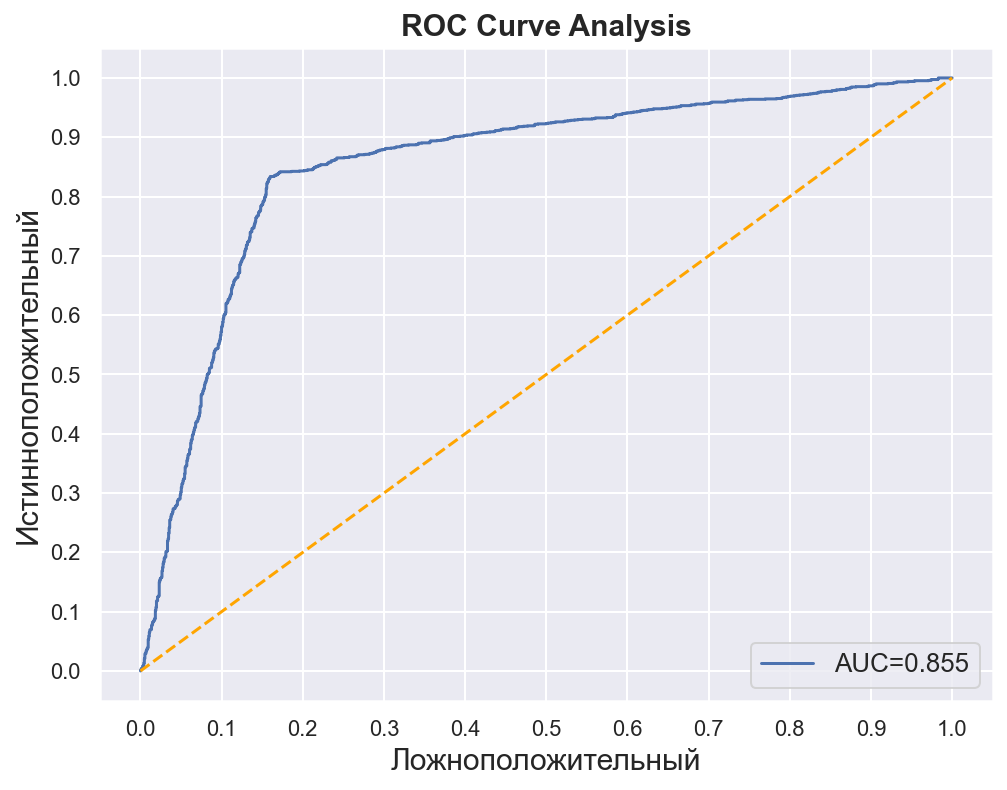

In [10]:
yproba = model.predict(X_test)
target = y_test
reset_averages(yproba)

order = np.argsort(-yproba)
top_k = int(0.10 * len(yproba))
yproba = yproba[order][:top_k]
target = target[order][:top_k]

fpr, tpr, _ = roc_curve(target,  yproba)
auc = roc_auc_score(target, yproba)
fig = plt.figure(figsize=(8,6))

plt.plot(fpr,          tpr, 
         label="AUC={:.3f}".format(auc))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')



plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Ложноположительный", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Истинноположительный", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()